In [ ]:
# Code block used for zipping files; Dont run this code again!

# import os
# from sklearn.model_selection import train_test_split
# import numpy as np

# from google.colab import drive
# drive.mount('/content/drive')
# cwd = os.getcwd()
# path = os.getcwd() + '/drive/MyDrive/ML Project/'
# os.chdir(path)
# !unzip ChestXRay2017.zip
# os.chdir(cwd)

file_name (train, test) => train,val,test => extract_feature(load image -> hog) ,
hog => svm (train,val), test

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os

import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from google.colab import drive
from sklearn.metrics import confusion_matrix

drive.mount('/content/drive')
path = 'drive/MyDrive/ML_Project/chest_xray/'
os.listdir(path)
plt.rcParams['figure.figsize']=14,8
RANDOM_SEED = 100


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_files(ds_path):
    unique_labels = os.listdir(ds_path)
    print(len(unique_labels))
    Images = []
    labels = []
    for i in range(len(unique_labels)):
        try:
          instances = os.listdir(ds_path + unique_labels[i])
          print(f"No. of {unique_labels[i]} instances = {len(instances)}")
          for img in instances:
              Images.append(ds_path + unique_labels[i]+"/"+img)
          labels.extend([unique_labels[i]]*len(instances))
        except Exception:
          print(f"Cant print for {unique_labels[i]}")
    return Images,labels

In [4]:
#Not creating a separate X_val as we might end up overfitting that while hyper parameter tuning, instead we'll try K-fold cross validation in this version
#Reference https://stats.stackexchange.com/questions/378771/cross-validation-and-train-test-split
#The previous version can be restored from 18 April'21 2:21 PM
X_train, y_train = load_files(path +'train/')
X_test, y_test = load_files(path +'test/')

import random
random.seed(RANDOM_SEED)
temp_train = list(zip(X_train, y_train))
# random.shuffle(temp_train)
X_train, y_train = zip(*temp_train)

temp_test = list(zip(X_test, y_test))
# random.shuffle(temp_test)
X_test, y_test = zip(*temp_test)

2
No. of NORMAL instances = 1349
No. of PNEUMONIA instances = 3884
2
No. of PNEUMONIA instances = 390
No. of NORMAL instances = 234


In [5]:
# (cv2.imread(X_train[4000]) - 127.5) / 127.5

In [6]:
assert len(X_train)==len(y_train)
assert len(X_test)==len(y_test)

print(f"Size of training set = {len(X_train)}")
print(f"Size of testing set = {len(X_test)}")

Size of training set = 5233
Size of testing set = 624


In [7]:
from skimage.feature import hog
def hog_img(img, size, display=False):
    resized_img = cv2.resize(img, size)

    #Resource for the different attributes: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
    features, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)

    if display:
        plt.imshow(hog_image,cmap='gray')

    return features


Text(0.5, 1.0, 'Hog Image')

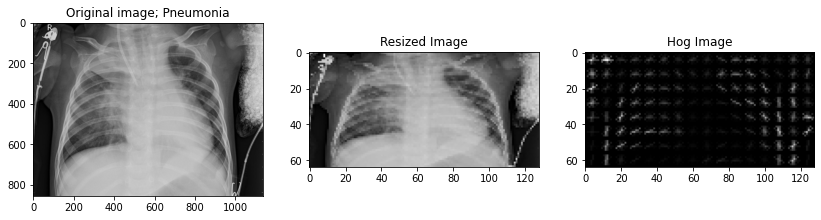

In [8]:
#Taking a look at the images
img = cv2.imread(X_train[4000])
plt.subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.title(f"Original image; Pneumonia" )

plt.subplot(1,3,2)
plt.imshow(cv2.resize(img, (128,64)),cmap='gray')
plt.title("Resized Image")

plt.subplot(1,3,3)
features=hog_img(img, (128,64), True)
plt.title("Hog Image")

In [9]:
class CustomDataset(Dataset):
    def __init__(self,X,Y):            
        self.X = X 
        self.Y = Y
        self.labels = {'PNEUMONIA':1,
                       'NORMAL':0}
    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx): 
        while 1: 
            try:
                label = self.labels[self.Y[idx]]
                dat =  (cv2.resize(cv2.imread(self.X[idx]),(128,128)) - 127.5) / 127.5 
                break
            except: 
                idx = int(np.random.random()*len(self.X))
        label = self.labels[self.Y[idx]]
        dat =  (cv2.resize(cv2.imread(self.X[idx]),(128,128)) - 127.5) / 127.5
        # print(dat.shape, label)
        dat = np.transpose(dat,(2,0,1))
        data = {'data': torch.tensor(dat,dtype = torch.float32) ,
                'label': torch.tensor(label,dtype = torch.float32)}
        
        return data
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
    
        self.m1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16,kernel_size = 5, stride = 1, padding = 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.MaxPool2d(kernel_size = 2),
            nn.LeakyReLU(negative_slope= 0.2),
            nn.Conv2d(in_channels = 16, out_channels = 32,kernel_size = 5, stride = 1, padding = 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.MaxPool2d(kernel_size = 2),
            nn.LeakyReLU(negative_slope= 0.2),
            nn.Conv2d(in_channels = 32, out_channels = 32,kernel_size = 5, stride = 1, padding = 2),
            nn.LeakyReLU(negative_slope= 0.2),
            nn.Conv2d(in_channels = 32, out_channels = 64,kernel_size = 5, stride = 1, padding = 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.MaxPool2d(kernel_size = 2),
            nn.LeakyReLU(negative_slope= 0.2)
        )
        self.m2 = nn.Sequential(
            nn.Linear(in_features = 16384 , out_features = 1024),
            nn.Dropout(p = 0.2),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(in_features = 1024, out_features = 512),
            nn.Dropout(p = 0.2),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(in_features= 512,out_features=256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(in_features= 256,out_features=1)
        )



    def forward(self,x):
        x = self.m1(x)
        x = torch.flatten(x, 1)
        x = self.m2(x)
        return torch.sigmoid(x).flatten()

In [10]:
path = path = 'drive/MyDrive/ML_Project/'
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

trainset = CustomDataset(X = X_train,Y=y_train)
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)
testset = CustomDataset(X = X_test,Y=y_test)
test_loader = DataLoader(testset, batch_size=16, shuffle=True, num_workers=4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters(),lr = 1e-4,betas=(0.9, 0.999),weight_decay= 1e-4)
criterion = nn.BCELoss()
epochs = 50
trained = False
save = True
train = True
log_interval = 10
train_losses = []
test_losses = []
test_accuracies = []
if trained: 
    d = torch.load( path+'MODEL_1.pth')
    model.load_state_dict(d['state_dict'])
    train_losses = d['train_losses']
    test_losses = d['test_losses']


In [18]:
idx, data = next(enumerate(train_loader)); print(data['data'].shape)
model(data['data'].to(device)).shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 3, 128, 128])


torch.Size([16])

In [ ]:
if train:

    for e in range(epochs):
        model.train()
        train_loss= 0 
        for idx, data in enumerate(train_loader):
            inpts = data['data'].to(device)
            target = data['label'].to(device)
            optimizer.zero_grad()
            output = model(inpts)
            loss = criterion(output,target)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    e, idx * len(inpts), len(train_loader.dataset),
                    100. * idx / len(train_loader), loss.item()))
                if save: 
                    d = {'state_dict':model.state_dict(),'train_losses':train_losses,'test_losses':test_losses, 'test_accuracies':test_accuracies}
                    torch.save(d, path+'MODEL_1.pth')
                    print("Model saved @ " + str(path+'MODEL_1.pth'))
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for idx, data in enumerate(test_loader):
                inpts = data['data'].to(device)
                target = data['label'].to(device)
                output = model(inpts)
                test_loss += criterion(output,target).item()
                pred = (output.data > 0.5).int()
                test_acc += (pred == target.data).sum()
            test_loss /= len(test_loader.dataset)
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, test_acc, len(test_loader.dataset),
                100. * test_acc /len(test_loader.dataset)))
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)       


In [28]:
optimizer = optim.Adam(model.parameters(),lr = 1e-4,betas=(0.9, 0.999),weight_decay= 1e-3)
train_losses = []
test_losses = []
test_accuracies = []

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy: 0.7532051205635071


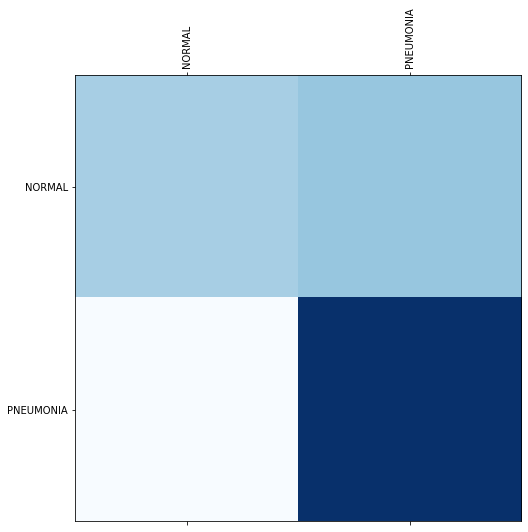

[[ 81 153]
 [  1 389]]


In [34]:
classes = ['NORMAL','PNEUMONIA']
label_GT = np.zeros((0,))
label_pred = np.zeros((0,))
acc = 0
model.eval()
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        inpts = data['data'].to(device)
        target = data['label'].to(device)
        probs = model(inpts)
        pred = (probs.data > 0.5).int()
        # features, labels = data[0].to(device), data[1].to(device)
        # pred = torch.exp(model(features)).data.max(1)[1]

        label_GT = np.concatenate([label_GT, target.cpu().numpy()])
        label_pred = np.concatenate([label_pred, pred.cpu().numpy()])
        acc += (pred == target).sum()
    
print("Test Accuracy: {}".format(acc / len(test_loader.dataset)))
mat = confusion_matrix(label_GT , label_pred)
plt.matshow(mat/mat.sum(1),cmap = plt.cm.Blues)
plt.xticks(range(2),classes, rotation = 'vertical')
plt.yticks(range(2),classes)
plt.show()
print(mat)


In [37]:
from sklearn.metrics import classification_report
print(classification_report(label_GT , label_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.35      0.51       234
         1.0       0.72      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.67       624
weighted avg       0.82      0.75      0.71       624

